# Categorical encodings

The data for this notebook comes from this kaggle [competition](https://www.kaggle.com/c/wids2018datathon/). You are given a dataset of survey questions and results from a developing country. Your goal is to predict the gender of the respondent based on the other answers he/she provided. You Kaggle api to get the data.

`pip install kaggle` <br/>

`kaggle competitions download -c wids2018datathon -p /data/yinterian/WiDS18`

In [70]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [111]:
import matplotlib.pyplot as plt

## Dataset

In [71]:
#PATH = Path("/data/yinterian/WiDS18/")
PATH = Path("/Users/yinterian/teaching/deeplearning/data/WiDS18/")

In [139]:
train = pd.read_csv(PATH/"train.csv", low_memory=False)
train.head()

,train_id,AA3,AA4,AA5,AA6,AA7,AA14,AA15,DG1,is_female,...,GN1,GN1_OTHERS,GN2,GN2_OTHERS,GN3,GN3_OTHERS,GN4,GN4_OTHERS,GN5,GN5_OTHERS
0,0,3,32,3.0,NaN,323011,3854,481,1975,1,...,99.0,NaN,99,NaN,99,NaN,99,NaN,99,NaN
1,1,2,26,NaN,8.0,268131,2441,344,1981,1,...,NaN,NaN,1,NaN,2,NaN,2,NaN,2,NaN
2,2,1,16,NaN,7.0,167581,754,143,1995,1,...,1.0,NaN,2,NaN,2,NaN,2,NaN,2,NaN
3,3,4,44,5.0,NaN,445071,5705,604,1980,1,...,NaN,NaN,2,NaN,2,NaN,99,NaN,99,NaN
4,4,4,43,NaN,6.0,436161,5645,592,1958,1,...,NaN,NaN,1,NaN,1,NaN,1,NaN,1,NaN


In [140]:
train.shape

(18255, 1235)

In [73]:
train = train.drop(columns=["train_id"])
train.head()

,AA3,AA4,AA5,AA6,AA7,AA14,AA15,DG1,is_female,DG3,...,GN1,GN1_OTHERS,GN2,GN2_OTHERS,GN3,GN3_OTHERS,GN4,GN4_OTHERS,GN5,GN5_OTHERS
0,3,32,3.0,NaN,323011,3854,481,1975,1,3,...,99.0,NaN,99,NaN,99,NaN,99,NaN,99,NaN
1,2,26,NaN,8.0,268131,2441,344,1981,1,8,...,NaN,NaN,1,NaN,2,NaN,2,NaN,2,NaN
2,1,16,NaN,7.0,167581,754,143,1995,1,3,...,1.0,NaN,2,NaN,2,NaN,2,NaN,2,NaN
3,4,44,5.0,NaN,445071,5705,604,1980,1,3,...,NaN,NaN,2,NaN,2,NaN,99,NaN,99,NaN
4,4,43,NaN,6.0,436161,5645,592,1958,1,3,...,NaN,NaN,1,NaN,1,NaN,1,NaN,1,NaN


## Cleaning columns with too many NAs

In [74]:
train["AA5"].isnull().sum()

12602

In [138]:
train.isnull().sum()

AA3                     0
AA4                     0
AA6                  5653
AA7                     0
AA14                    0
AA15                    0
DG1                     0
is_female               0
DG3                     0
DG3A                    0
DG4                     0
DG5_1                   0
DG5_2                   0
DG5_3                   0
DG5_4                   0
DG5_5                   0
DG5_6                   0
DG5_7                   0
DG5_8                   0
DG5_9                   0
DG5_10                  0
DG5_11                  0
DG5_96                  0
DG6                     0
DG8a                    0
DG8b                    0
DG8c                    0
DG9a                  232
DG9b                10018
DG9c                11451
                    ...  
FB27_1                  0
FB27_2                  0
FB27_3                  0
FB27_4                  0
FB27_5                  0
FB27_6                  0
FB27_7                  0
FB27_8      

In [76]:
## dropping columns with too many nulls
for col in train.columns:
    if train[col].isnull().sum() > 12000:
        #print(col, train[col].isnull().sum())
        train.drop(col, axis=1, inplace=True)

In [77]:
# just kept 421 columns
train.head()

,AA3,AA4,AA6,AA7,AA14,AA15,DG1,is_female,DG3,DG3A,...,LN2_2,LN2_3,LN2_4,LN2_RIndLngBEOth,LN2_WIndLngBEOth,GN1,GN2,GN3,GN4,GN5
0,3,32,NaN,323011,3854,481,1975,1,3,4,...,1,1,1,NaN,NaN,99.0,99,99,99,99
1,2,26,8.0,268131,2441,344,1981,1,8,4,...,1,3,4,Bengali,Bengali,NaN,1,2,2,2
2,1,16,7.0,167581,754,143,1995,1,3,2,...,1,2,2,Hindi,Hindi,1.0,2,2,2,2
3,4,44,NaN,445071,5705,604,1980,1,3,4,...,1,4,5,Tamil,Tamil,NaN,2,2,99,99
4,4,43,6.0,436161,5645,592,1958,1,3,4,...,4,4,4,Malayalam,Malayalam,NaN,1,1,1,1


In [78]:
train.shape

(18255, 421)

In [79]:
train.to_csv(PATH/"train_421_cols.csv", index=False)

## Picking columns for embeddings

In [80]:
train = pd.read_csv(PATH/"train_421_cols.csv")

In [81]:
Y = train["is_female"].values.astype(np.float32)
X = train.drop(columns=["is_female"])

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
for col in X.columns:
    if X.dtypes[col] == "object":
        X[col] = X[col].fillna("NA")
    else:
        X[col] = X[col].fillna(0)
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [83]:
for col in X.columns:
    X[col] = X[col].astype('category')

In [84]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=3)
X_train.head()

,AA3,AA4,AA6,AA7,AA14,AA15,DG1,DG3,DG3A,DG4,...,LN2_2,LN2_3,LN2_4,LN2_RIndLngBEOth,LN2_WIndLngBEOth,GN1,GN2,GN3,GN4,GN5
11369,1,10,2,424,482,252,62,2,3,4,...,0,0,0,38,38,0,1,1,1,1
1250,2,17,1,831,831,410,63,2,3,5,...,0,3,3,33,32,1,2,2,0,0
7527,1,8,0,301,310,166,53,2,3,0,...,0,0,0,38,38,2,1,1,1,1
13476,2,14,2,664,564,300,69,2,3,4,...,2,2,2,14,14,3,2,2,2,2
13406,0,12,3,587,111,76,58,2,3,2,...,1,3,3,14,14,1,0,2,2,2


In [141]:
# number of categories for categories with more than 2 categories
emb_c = {n: len(col.cat.categories) for n,col in X.items() if len(col.cat.categories) > 2}
emb_c

{'AA3': 4,
 'AA4': 22,
 'AA6': 4,
 'AA7': 1050,
 'AA14': 907,
 'AA15': 450,
 'DG1': 79,
 'DG3': 9,
 'DG3A': 8,
 'DG4': 12,
 'DG6': 9,
 'DG8a': 13,
 'DG8b': 13,
 'DG8c': 13,
 'DG9a': 12,
 'DG9b': 11,
 'DG9c': 8,
 'DG10b': 9,
 'DG10c': 8,
 'DG11b': 9,
 'DL1': 12,
 'DL2': 33,
 'DL3': 3,
 'DL5': 25,
 'DL7': 3,
 'DL8': 342,
 'DL11': 15,
 'DL14': 24,
 'DL15': 4,
 'DL24': 7,
 'MT1': 13,
 'MT1A': 8,
 'MT3_1': 5,
 'MT3_2': 6,
 'MT3_3': 6,
 'MT4_1': 3,
 'MT4_2': 3,
 'MT4_3': 3,
 'MT4_4': 3,
 'MT4_5': 3,
 'MT4_6': 3,
 'MT5': 8,
 'MT6': 10,
 'MT6A': 7,
 'MT6B': 9,
 'MT6C': 28,
 'MT7': 3,
 'MT11': 83,
 'MT12_1': 5,
 'MT12_2': 7,
 'MT12_3': 6,
 'MT12_4': 3,
 'MT12_5': 3,
 'MT12_7': 5,
 'MT12_9': 3,
 'MT12_11': 5,
 'MT12_12': 3,
 'MT12_13': 3,
 'MT12_14': 3,
 'MT14C_1': 5,
 'MT14C_2': 5,
 'MT14C_3': 5,
 'MT14C_4': 5,
 'MT15': 3,
 'MT17_1': 7,
 'MT17_2': 7,
 'MT17_3': 7,
 'MT17_4': 7,
 'MT17_5': 7,
 'MT17_6': 7,
 'MT17_7': 7,
 'MT17_8': 7,
 'MT17_9': 7,
 'MT17_10': 7,
 'MT17_11': 7,
 'MT17_12': 7,
 'M

In [142]:
# size of the category, size of the embedding
# 30 and (c+1)//2) are arbitrary (we should play with these numbers)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
emb_szs

[(4, 2),
 (22, 11),
 (4, 2),
 (1050, 50),
 (907, 50),
 (450, 50),
 (79, 40),
 (9, 5),
 (8, 4),
 (12, 6),
 (9, 5),
 (13, 7),
 (13, 7),
 (13, 7),
 (12, 6),
 (11, 6),
 (8, 4),
 (9, 5),
 (8, 4),
 (9, 5),
 (12, 6),
 (33, 17),
 (3, 2),
 (25, 13),
 (3, 2),
 (342, 50),
 (15, 8),
 (24, 12),
 (4, 2),
 (7, 4),
 (13, 7),
 (8, 4),
 (5, 3),
 (6, 3),
 (6, 3),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (8, 4),
 (10, 5),
 (7, 4),
 (9, 5),
 (28, 14),
 (3, 2),
 (83, 42),
 (5, 3),
 (7, 4),
 (6, 3),
 (3, 2),
 (3, 2),
 (5, 3),
 (3, 2),
 (5, 3),
 (3, 2),
 (3, 2),
 (3, 2),
 (5, 3),
 (5, 3),
 (5, 3),
 (5, 3),
 (3, 2),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (7, 4),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (18, 9),
 (27, 14),
 (3, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (5, 3),
 (4, 2),
 (3, 2),
 (7, 4),
 (3, 2

In [144]:
emb_cols = emb_c.keys()
emb_cols

dict_keys(['AA3', 'AA4', 'AA6', 'AA7', 'AA14', 'AA15', 'DG1', 'DG3', 'DG3A', 'DG4', 'DG6', 'DG8a', 'DG8b', 'DG8c', 'DG9a', 'DG9b', 'DG9c', 'DG10b', 'DG10c', 'DG11b', 'DL1', 'DL2', 'DL3', 'DL5', 'DL7', 'DL8', 'DL11', 'DL14', 'DL15', 'DL24', 'MT1', 'MT1A', 'MT3_1', 'MT3_2', 'MT3_3', 'MT4_1', 'MT4_2', 'MT4_3', 'MT4_4', 'MT4_5', 'MT4_6', 'MT5', 'MT6', 'MT6A', 'MT6B', 'MT6C', 'MT7', 'MT11', 'MT12_1', 'MT12_2', 'MT12_3', 'MT12_4', 'MT12_5', 'MT12_7', 'MT12_9', 'MT12_11', 'MT12_12', 'MT12_13', 'MT12_14', 'MT14C_1', 'MT14C_2', 'MT14C_3', 'MT14C_4', 'MT15', 'MT17_1', 'MT17_2', 'MT17_3', 'MT17_4', 'MT17_5', 'MT17_6', 'MT17_7', 'MT17_8', 'MT17_9', 'MT17_10', 'MT17_11', 'MT17_12', 'MT17_13', 'MT18_1', 'MT18_2', 'MT18_3', 'MT18_4', 'MT18_5', 'MT18_6', 'MT18_96', 'MT18_8', 'FF2', 'FF2A', 'FF3', 'FF4', 'FF5', 'FF6_1', 'FF6_2', 'FF6_3', 'FF6_4', 'FF6_5', 'FF6_6', 'FF6_7', 'FF6_8', 'FF6_9', 'FF6_10', 'FF7_1', 'FF7_2', 'FF7_4', 'FF7_5', 'FF7_6', 'FF9', 'FF10_1', 'FF10_2', 'FF10_3', 'FF10_4', 'FF10_5', '

## Dataset
Dataset is a custom class to conveniently interact with a set observations. Designing this Dataset class is up to you.

In [147]:
# all variables are categorical, but some of them has just two values 
# emb_c are the variables we plan to embed
class WiDSDataset(Dataset):
    def __init__(self, X, Y, emb_cols):
        X = X.copy()
        # splitting categorical columns and numerical columns
        self.X1 = X.loc[:,emb_cols].copy().values.astype(np.int64)
        self.X2 = X.drop(columns=emb_cols).copy().values.astype(np.float32)
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return [self.X1[idx], self.X2[idx], self.y[idx]]

In [89]:
train_ds = WiDSDataset(X_train, y_train, emb_cols)
valid_ds = WiDSDataset(X_val, y_val, emb_cols)

In [146]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [91]:
valid_ds[0]

[array([  0,   4,   3, 200, 229, 129,  72,   0,   3,   5,   2,   5,   3,
          1,   3,   0,   0,   3,   0,   3,   5,   0,   0,   0,   1, 136,
          0,   8,   3,   0,   1,   7,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   2,   0,   0,   1,   3,
          1,   3,   2,   1,   2,   3,   2,   2,   2,   0,   0,   1,   0,
          0,   4,   1,   2,   2,   2,   2,   2,   2,   1,   1,   1,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   4,   4,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2,   2,   2,   0,   2,   2,   6,   6,   6,   6,   6,   6,
          1,   6,   6,   6,   6,   6,   6,   6,   0

## Model

In [93]:
# modified from fast.ai
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        n_emb = sum(e.embedding_dim for e in self.embs) 
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 100)
        self.lin2 = nn.Linear(100, 1)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(100)
        self.emb_drop = nn.Dropout(0.5)
        self.drops = nn.Dropout(0.2)
        

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = self.lin2(x)
        return x

In [94]:
model = MixedInputModel(emb_szs, 172)

In [149]:
x1, x2, y = next(iter(train_dl))
print(x1.shape, x2.shape, y.shape)

torch.Size([5, 248]) torch.Size([5, 172]) torch.Size([5])


In [95]:
y = y.unsqueeze(1)
out = model(x1, x2)
out

tensor([[-0.3739],
        [-0.2280],
        [-0.2244],
        [-0.1472],
        [ 0.6558]])

In [150]:
out.shape

torch.Size([5, 1])

In [96]:
pred = (out > 0.0).float()

In [97]:
(pred == y).float().sum()

tensor(2.)

In [98]:
F.binary_cross_entropy_with_logits(out, y)

tensor(0.7528)

## Training

In [99]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [100]:
def train_model(model, optim, train_dl=train_dl, verbose=False):
    model.train()
    total = 0
    sum_loss = 0
    for i, (x1, x2, y) in enumerate(train_dl):
        batch = y.shape[0]
        y = y.unsqueeze(1)  
        out = model(x1, x2)
        loss = F.binary_cross_entropy_with_logits(out, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
        if verbose: print(sum_loss/total)
    return sum_loss/total

In [101]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for i, (x1, x2, y) in enumerate(valid_dl):
        batch = y.shape[0]
        y = y.unsqueeze(1)
        out = model(x1, x2)
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = (out > 0).float()
        correct += (pred == y).float().sum().item()
    print("val loss", sum_loss/total, correct/total)
    return sum_loss/total, correct/total

In [102]:
from datetime import datetime

def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print("loss ", loss)
        val_loss(model, valid_dl)

In [53]:
batch_size = 500
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [67]:
model = MixedInputModel(emb_szs, 172) #.cuda()

In [68]:
# Try the higest learning rate that doesn't cycle 
#optim = get_optimizer(model, lr = 0.1, wd = 0.0)
#train_model(model, optim, train_dl, verbose=True)

In [69]:
train_loop(model, epochs=10, lr=0.05, wd=0.00001)

loss  0.40963991163887736
val loss 0.28050583809148905 0.8871542043275815
loss  0.2726559068235232
val loss 0.24683427480892495 0.8948233360723089
loss  0.2425833026151793
val loss 0.24767417169880848 0.8970145165708026
loss  0.22993842451760488
val loss 0.24438396030519147 0.9052314434401534
loss  0.22175926448008484
val loss 0.2435034419642315 0.9022185702547247
loss  0.21122783194728434
val loss 0.24742723562658012 0.9008490824431663
loss  0.2104358298668826
val loss 0.2554055783592554 0.9003012873185429
loss  0.2009587569029094
val loss 0.2585757545814616 0.8994795946316078
loss  0.19249877350782899
val loss 0.26678937042585565 0.9019446726924131
loss  0.19240531748580594
val loss 0.25379587123407726 0.8953711311969323


## Learning rate (LR) range test
The [learning rate range test](https://arxiv.org/abs/1506.01186) is a way to estimate minimum and maximum boundary values for learning rates.

In [103]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [108]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for j, (x1, x2, y) in enumerate(train_dl):
            # changing learning rate at each iteration
            optim = get_optimizer(model, lr=lrs[ind])
            batch = y.shape[0]
            y = y.unsqueeze(1)  
            out = model(x1, x2)
            loss = F.binary_cross_entropy_with_logits(out, y)   
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses

In [122]:
batch_size = 500
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
model = MixedInputModel(emb_szs, 172)

In [115]:
# lr_low, lr_high and batch_size are important so that the plot gives
# useful information
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.2)

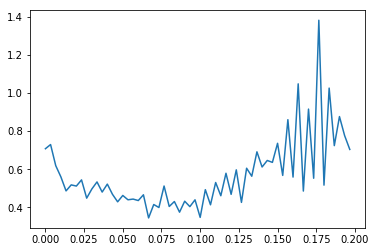

In [116]:
plt.plot(lrs, losses)
#plt.plot(lrs[:30], losses[:30])
plt.show()

Pick the lower boundary as the value of the learning rate when the loss starts to decrease. Pick the upper learning rate when the loss slows, becomes ragged or increases. From this graph I would try $base\_lr=1e-5$ and $max\_lr=0.1$

## One cycle learning rate policy


In [117]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

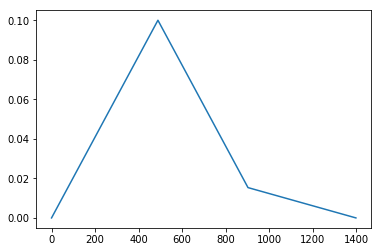

In [151]:
lrs = get_triangular_lr2(1e-5, 0.1, 700)
plt.plot(lrs)
plt.show()

In [130]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.01, epochs=4):
    idx = 0
    stepesize = (epochs//2)*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x1, x2, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd = 0.00001)
            batch = y.shape[0]
            y = y.unsqueeze(1)  
            out = model(x1, x2)
            loss = F.binary_cross_entropy_with_logits(out, y) 
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_loss(model, valid_dl)
    return sum_loss/total

In [134]:
model = MixedInputModel(emb_szs, 172)

In [136]:
train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-6, lr_high=0.08, epochs=8)

train loss 0.24587600113136807
val loss 0.24231754755588533 0.9046836483155299
train loss 0.27715584174537294
val loss 0.2697011732264957 0.8912626677622569
train loss 0.3259971583013631
val loss 0.325057807229245 0.8803067652697891
train loss 0.30987580536457326
val loss 0.26951411781132106 0.8945494385099972
train loss 0.2618389627241951
val loss 0.2285546188287884 0.9063270336894002
train loss 0.2426936120790705
val loss 0.22571344336918758 0.9098877019994522
train loss 0.23826666781997655
val loss 0.22648271440773982 0.9060531361270885
train loss 0.2324035341847077
val loss 0.22461075986110815 0.9101615995617639


0.2324035341847077

## Lab

1. Get a better validation score by hyper-parameter tunning.